In [1]:

#! Todos los Imports del proyecto
import shutil
import getpass
import sys
import time
import os
import zipfile
import pandas as pd
from collections import Counter
import subprocess

In [2]:
#? Variables importantes para el módelo.

dataset_id = 'giovanijazin/birds-penguins-and-flamingo'
zip_filename = 'birds-penguins-and-flamingo.zip'
dataset_name = 'birds-penguins-and-flamingo'
yaml_path = "./datasets/birds-penguins-and-flamingo/data.yaml"
id_file = "1_57rJzP3h8k9V893Lt8XnkV9ZvSCpZ7H"
drive_filename = "project.zip"


<h1>Funciones para la configuración de entornos y rutas del sistema</h1>

Configuración de entornos y rutas del sistema en esta parte nos enfocaremos en la configuración de los entornos de <span style="color: orange;">collab</span> y <span style="color:skyblue;">local</span>, siendo estos la estructura en la que nuestro proyecto se desarrollará.

In [3]:

def enviroment_detector():
    """
    Esta función detecta en que entorno
    se está ejecutando sea en un entorno de collab o en local
    """

    if 'COLAB_GPU' in os.environ or 'google.colab' in str(get_ipython()):
        return 'colab'
    else:
        return 'local'


def path_builder(zip_filename: str, dataset_name: str):
    """
    Esta función se encarga de construir y remapear las rutas
    del proyecto en función del entorno en el que se está ejecutando.
    Args:
        zip_filename (str): Nombre del archivo ZIP descargado
        dataset_name (str): Nombre de la carpeta del dataset.

    Returns:
        str: La ruta base del dataset descomprimido.
    """

    enviroment = enviroment_detector()
    dataset_base_dir = 'datasets'

    if enviroment == 'colab':
        base_dir = '/content'
    else:
        base_dir = os.getcwd()

    zip_path = os.path.join(base_dir, zip_filename)
    extract_path = os.path.join(base_dir, dataset_base_dir, dataset_name)

    print(f"Entorno: {enviroment}")
    print(f"Ruta de extracción: {extract_path}")

    #? Comprueba si existen los directorios base y sino, los crea.

    if not os.path.exists(extract_path):
        os.makedirs(extract_path, exist_ok=True)

    #? Comprueba s el archivo zip existe
    if os.path.exists(zip_path):
        #? Comprueba si el archivo fue descomprimido.
        if not os.path.exists(os.path.join(extract_path, "train/images")):
            print("Descomprimiendo el archivo zip...")
            try:
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_path)
                print("Archivo zip descomprimido exitosamente.")
            except Exception as e:
                print(f"Error al descomprimir el archivo zip: {e}")
        else:
            print("El archivo zip ya ha sido descomprimido.")
    else:
        print(f"El archivo'{zip_filename}'no existe en' {base_dir}")


    return extract_path




In [4]:


def get_dependencies(id_file: str, drive_filename: str):
    """
    Descarga un archivo ZIP de Google Drive, lo descomprime en una carpeta temporal
    ('project'), mueve su contenido a la raíz y limpia la carpeta temporal.

    Args:
        id_file (str): ID del archivo ZIP en Google Drive.
        drive_filename (str): Nombre del archivo ZIP esperado (ej: 'dataset.zip').
    """

    extract_path = "project"

    # 1. VERIFICACIÓN Y DESCARGA (Usando subprocess para gdown)
    try:
        if os.path.exists(drive_filename):
            print(f"✅ Archivo '{drive_filename}' ya ha sido descargado. Omite descarga.")
        else:
            print(f"Descargando el archivo con ID: {id_file}...")

            # Ejecutar gdown. -O $drive_filename especifica el nombre del archivo de salida
            subprocess.run(
                ['gdown', '--id', id_file, '-O', drive_filename],
                check=True,  # Lanza un error si gdown falla
                capture_output=True,
                text=True
            )
            print("✅ Descarga de Google Drive completada.")

    except subprocess.CalledProcessError as e:
        print(f"❌ ERROR al descargar el archivo de Drive (ID: {id_file}).")
        print("   Verifica que el ID sea correcto y que gdown esté instalado.")
        print(f"   Salida de error: {e.stderr}")
        return # Salir si la descarga falla

    except Exception as e:
        print(f"❌ ERROR general en la descarga: {e}")
        return # Salir si la descarga falla

    if not drive_filename.lower().endswith(".zip"):
        return
    # 2. DESCOMPRIMIR
    try:
        if not os.path.exists(extract_path):
            os.makedirs(extract_path, exist_ok=True)

        print(f"Descomprimiendo '{drive_filename}' en '{extract_path}'...")
        with zipfile.ZipFile(drive_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("✅ Archivo zip descomprimido exitosamente.")

    except Exception as e:
        print(f"❌ Error al descomprimir el archivo zip: {e}")
        return

    #? 3. MOVER CONTENIDOS A LA RAÍZ Y LIMPIEZA

    # Verificamos si la carpeta temporal tiene subcarpetas (común en ZIPs)
    contents = os.listdir(extract_path)
    if len(contents) == 1 and os.path.isdir(os.path.join(extract_path, contents[0])):
        # Si el ZIP extrajo solo una subcarpeta (ej: 'dataset_name/'), movemos desde dentro de esa subcarpeta
        source_dir = os.path.join(extract_path, contents[0])
    else:
        # Si el ZIP extrajo los archivos directamente en 'project/'
        source_dir = extract_path

    print(f"Moviendo contenidos de {source_dir} a la raíz del proyecto...")

    try:
        for item in os.listdir(source_dir):
            s = os.path.join(source_dir, item)
            d = os.path.join(".", item) # Mover al directorio actual (raíz)

            # Usar rename es más eficiente que move/copy si es posible
            shutil.move(s, d)

        print("✅ Contenidos movidos exitosamente.")

    except Exception as e:
        print(f"❌ Error al mover los archivos: {e}")
        # Intentamos seguir, pero los archivos pueden estar en la carpeta 'project'

    # 4. BORRAR CARPETA TEMPORAL
    # Borramos la carpeta temporal (y la posible subcarpeta que haya quedado)
    try:
        if os.path.exists(extract_path):
            shutil.rmtree(extract_path)
            print(f"✅ Carpeta temporal '{extract_path}' eliminada.")

    except Exception as e:
        print(f"❌ Error al eliminar la carpeta temporal '{extract_path}': {e}")

Configuración de la API nde Kaggle en base al entorno de ejecución y el sistema operativo.

In [5]:


def kaggle_setup(file_name: str = 'kaggle.json'):
    """
    Esta función se encargar de configurar, subir,
    mover la API conseguida en Kaggle.

    """

    enviroment = enviroment_detector()
    kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
    dest_file = os.path.join(kaggle_dir, file_name)

    if  os.path.exists(zip_filename):
        print("El archivo '{zip_filename}' encontrado con éxito.")
        return

    else:
            if not os.path.exists(kaggle_dir):
                os.makedirs(kaggle_dir, exist_ok=True)

            if os.path.exists(dest_file):
                print(f"El archivo '{file_name}'ya existe.")
                return

            if enviroment == 'colab':
                print("El enviroment en uso es Colab")
                try:
                    from google.colab import files
                    print("Por favor suba el archivo kaggle.json")
                    uploaded = files.upload()

                    if file_name in uploaded:
                        shutil.move(file_name, dest_file)
                        print(f"Archivo '{file_name}' subido y movido exitosamente. in {dest_file}")
                    else:
                        print(f"Archivo selecionado es incorrecto.")
                except ImportError:
                    print("No se pudo usar el arhivo. Intenta la configuración manual.")

            else:
                print("El enviroment en uso es local")
                source_file = os.path.join(os.getcwd(), file_name)

                if os.path.exists(source_file):
                    try:
                        shutil.copy2(source_file, dest_file)
                        print(f"El archivo '{file_name}' copiado con éxito")
                    except Exception as e:
                        print(f"Error al copiar el archivo '{file_name}': {str(e)}")
                        return
                else:
                    print(f"Error el archivo '{file_name}' no fue encontrado. \n Por favor colocar el archivo en {os.getcwd()}")

                #? Si el sistenma operativo no es Windows
                if os.name != 'nt':
                    os.chmod(dest_file, 0o600)

In [6]:
try:
    get_dependencies(id_file, drive_filename)
    print("Archivos descargados éxitosamente.")
    !pip install -r requirements.txt
except:
        kaggle_setup()


Descargando el archivo con ID: 1_57rJzP3h8k9V893Lt8XnkV9ZvSCpZ7H...
✅ Descarga de Google Drive completada.
Descomprimiendo 'project.zip' en 'project'...
✅ Archivo zip descomprimido exitosamente.
Moviendo contenidos de project/project a la raíz del proyecto...
✅ Contenidos movidos exitosamente.
✅ Carpeta temporal 'project' eliminada.
Archivos descargados éxitosamente.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.1 MB/s eta 0:00:00


In [7]:
from IPython.utils.capture import capture_output


def dataset_request(dataset_request_id: str, zip_filename: str):
    """
    Esta función hace la solicitud del dataset de Kaggle y descarga el zip.

    Args:
        dataset_request_id(str): El identificador del dataset (ej. 'giovanijazin/birds-penguins-and-flamingo')
        zip_filename (str): Nombre del archivo ZIP esperado (ej. 'birds-penguins-and-flamingo.zip').
    """

    from kaggle.api.kaggle_api_extended import KaggleApi

    print("Descargando el dataset...")
    try:
        api = KaggleApi()
        api.authenticate()

        api.dataset_download_files(dataset_request_id)
        print(f"Dataset '{zip_filename}' descargado correctamente.")
    except Exception as e_api:
        print(f"ERROR: No se pudo descargar el dataset '{zip_filename}' a través de API. \n Intentando a través de comandos.")

        try:
            download_command = ['kaggle', 'datasets', 'download', dataset_request_id, '-o']
            #os.system(f"kaggle datasets download -d {dataset_request_id}") alternativa de momento.
            subprocess.run(download_command,
                            check = True,
                            capture_output= True,
                            text=True
                            )
            print(f"Descarga completada del dataset '{zip_filename}' usando el comando '{download_command}'")
        except FileNotFoundError:
            print(f"ERROR: No se encontró el comando Kaggle por favor instala (pip install kaggle)")
        except subprocess.CalledProcessError as e_cmd:
            print(f"Error de Comando: Por favor revisa las credenciales o el nombre del Dataset")
            print(f"Salida de Error: {e_cmd.stderr}")

        except Exception as e_cmd_gen:
            print(f"ERROR DESCONOCIDO al usar el comando de terminal: {e_cmd_gen}")

    if os.path.exists(zip_filename):
        print("Dataset descargado correctamente.")
    else:
        print(f"ERROR: El archivo '{zip_filename}' no se encontró. Verifica las credenciales de Kaggle y la ruta.")
    if zip_filename == 'Twice-One-In-A-Million.zip':
        print("""⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀
⣠⣴⢟⣶⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣴⣾⠀⠀⠀⠀⠀
⠀⠾⠋⠙⠂⢀⣠⣴⣶⣶⣶⣾⣿⣿⣟⣹⣾⠇⠀⠀⠀⠀⠀
⠀⠀⠀⢠⣶⣿⠿⠿⣿⣿⢿⡻⢿⡟⠿⠟⠁⠀⠀⠀⠀⠀⠀
⠀⠀⣰⡟⠁⠀⠀⣸⣿⣿⡿⠀⠀⠀⠀⠀⣀⡀⢀⡀⠀⠀⠀
⠀⢰⣿⡅⠀⠀⠀⣾⣿⣷⠁⠀⠀⠀⠀⢿⣿⣿⣮⣿⠂⠀⠀
⠀⢸⣿⣿⣄⠀⢠⣿⣿⠇⢠⣿⣿⣿⡄⠀⣿⣿⡏⠀⠀⠀⠀
⠀⠈⠛⠋⠀⠀⢸⣿⣿⠀⢾⣿⢩⣿⠇⠀⣿⣿⠏⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠸⣿⣿⡀⠘⣿⣾⠏⠁⣰⣿⡟⠀⠀⢀⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⠿⣿⡶⠟⢿⣶⣾⡿⠋⠀⣯⠚⢹⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠲⡴⠊⠁
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀""")

In [8]:

try:
    if not os.path.exists(zip_filename):
        dataset_request(dataset_id, zip_filename)

    path_builder(zip_filename, dataset_name)
except Exception as e:
    print(f"Error al descargar el dataset: {e}")


Entorno: colab
Ruta de extracción: /content/datasets/birds-penguins-and-flamingo
Descomprimiendo el archivo zip...
Archivo zip descomprimido exitosamente.


<H2>Estructuración YOLO </H2>

En este apartado configuramos el <span style="color:red">data.yaml</span> el cual será fundamental para la estructura de nuestros modelos.


In [9]:
import yaml
from ultralytics import YOLO
data = {
    'path': './datasets/birds-penguins-and-flamingo',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': {
        0: 'Flamingo',
        1: 'Penguin'
    }
}

with open('./datasets/birds-penguins-and-flamingo/data.yaml', 'w') as file:
    yaml.dump(data, file,
              default_flow_style=False,
              sort_keys=False)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [10]:
# 1. Cargar el modelo (nano, el más pequeño)
inicio = time.time()
model = YOLO("yolo11n.pt")

# Afinar el modelo
baseline_n = model.train(data="./datasets/birds-penguins-and-flamingo/data.yaml",
                      epochs=50, # Número de iteraciones
                      imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                      #batch = 32,
                      #patience = 10, #Si en 5 épocas seguidas no mejora el mAP, para el entrenamiento
                      plots=True, # Guardar gráficos de entrenamiento
                      name = "baseline_n"
                      )
fin = time.time()

time_baseline_n = fin - inicio

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

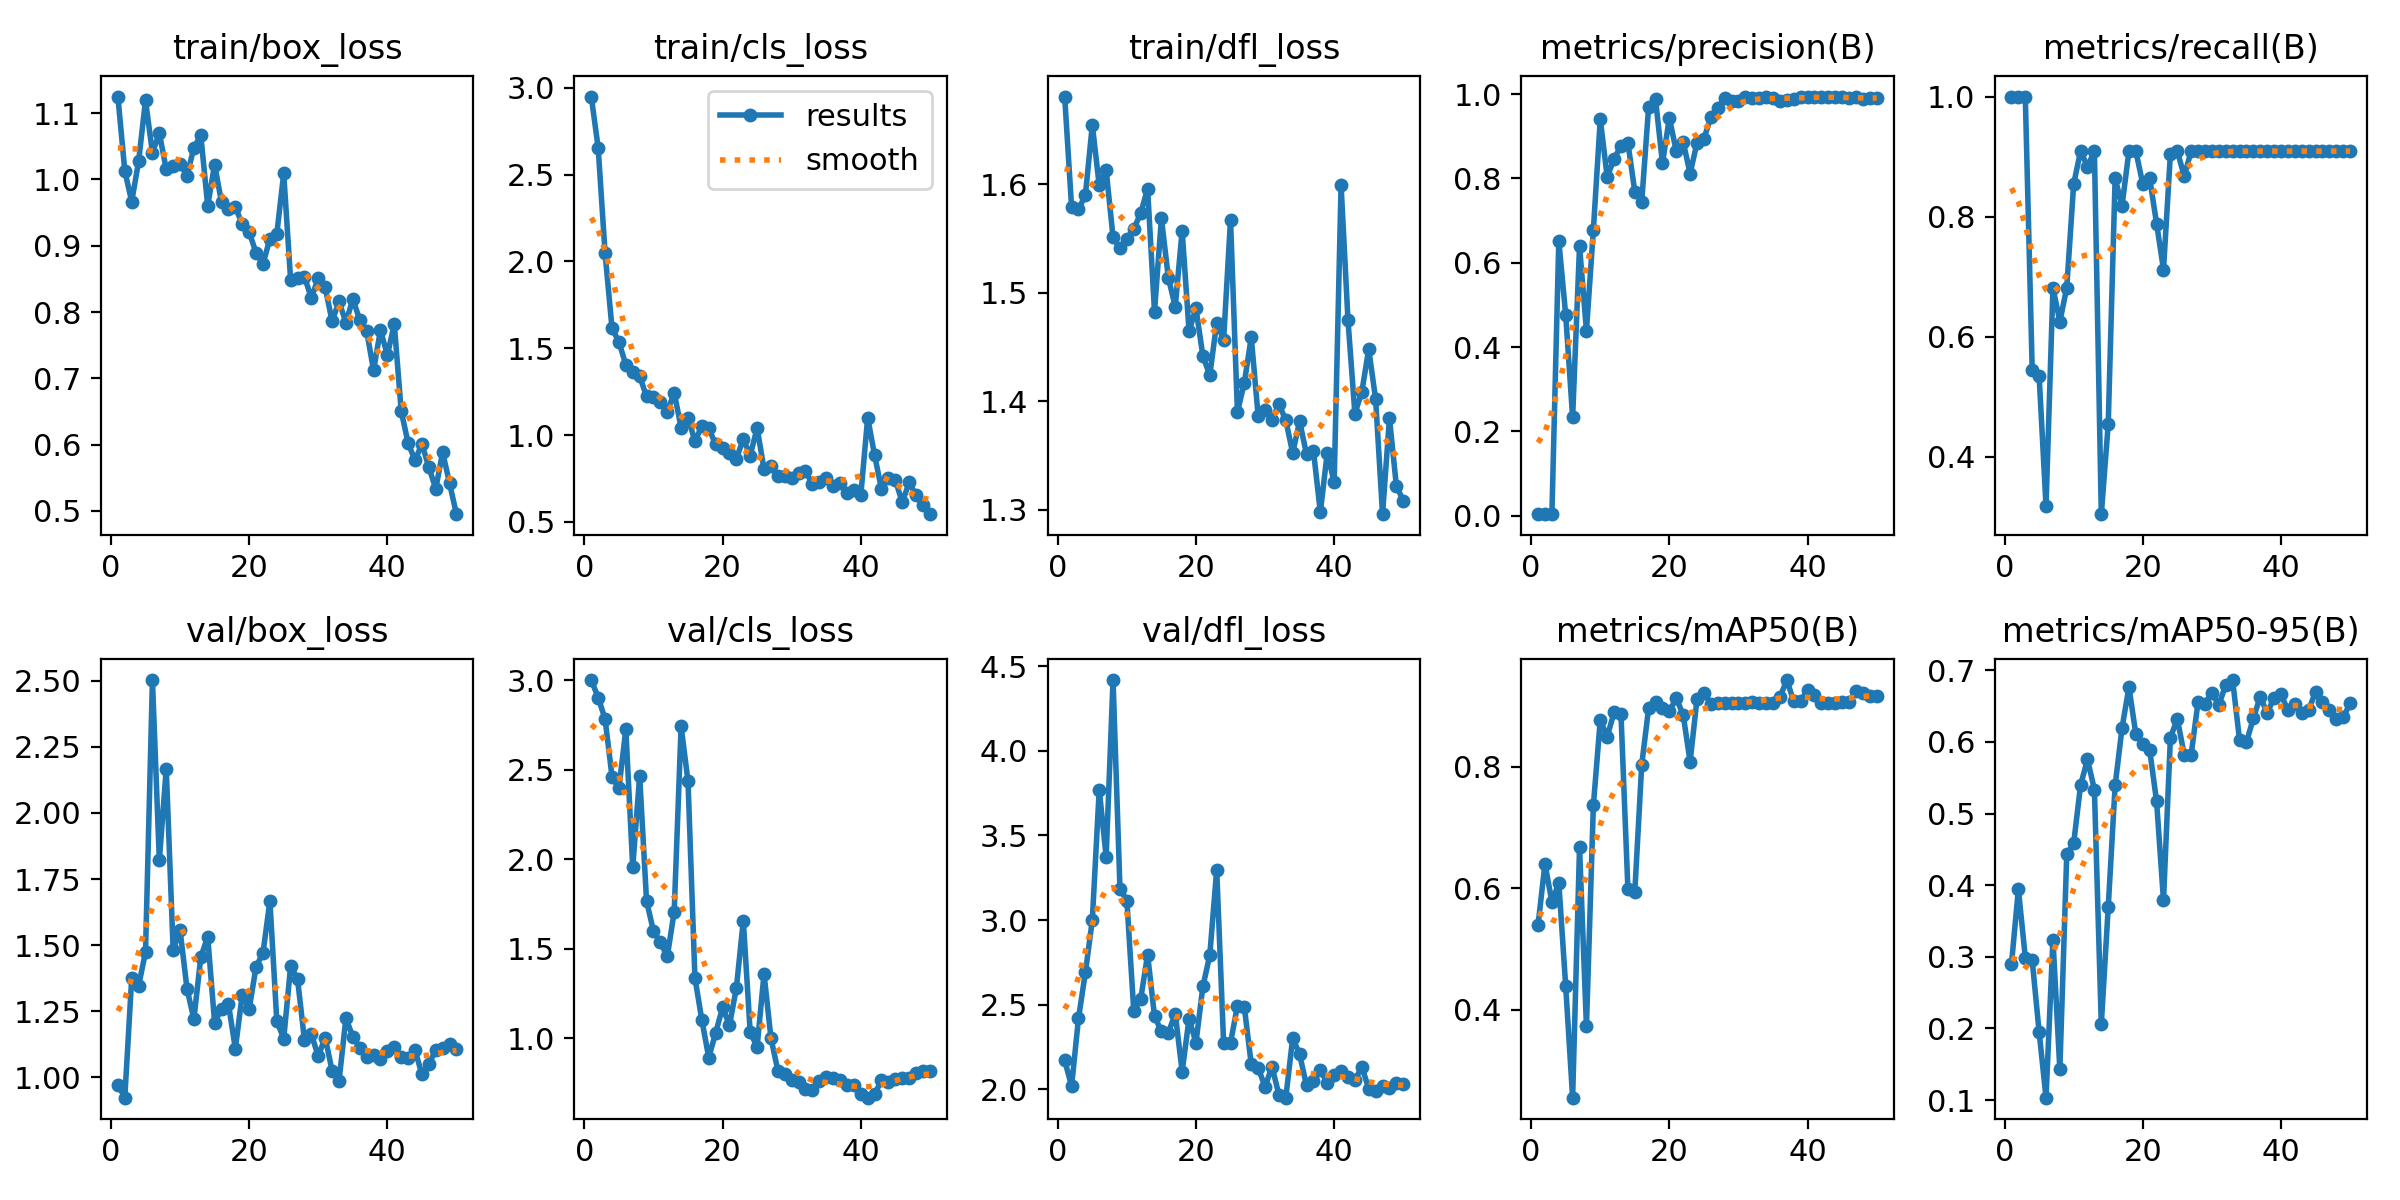

In [11]:
from IPython.display import Image as IPyImage

IPyImage(filename='./runs/detect/baseline_n/results.png', width=800)

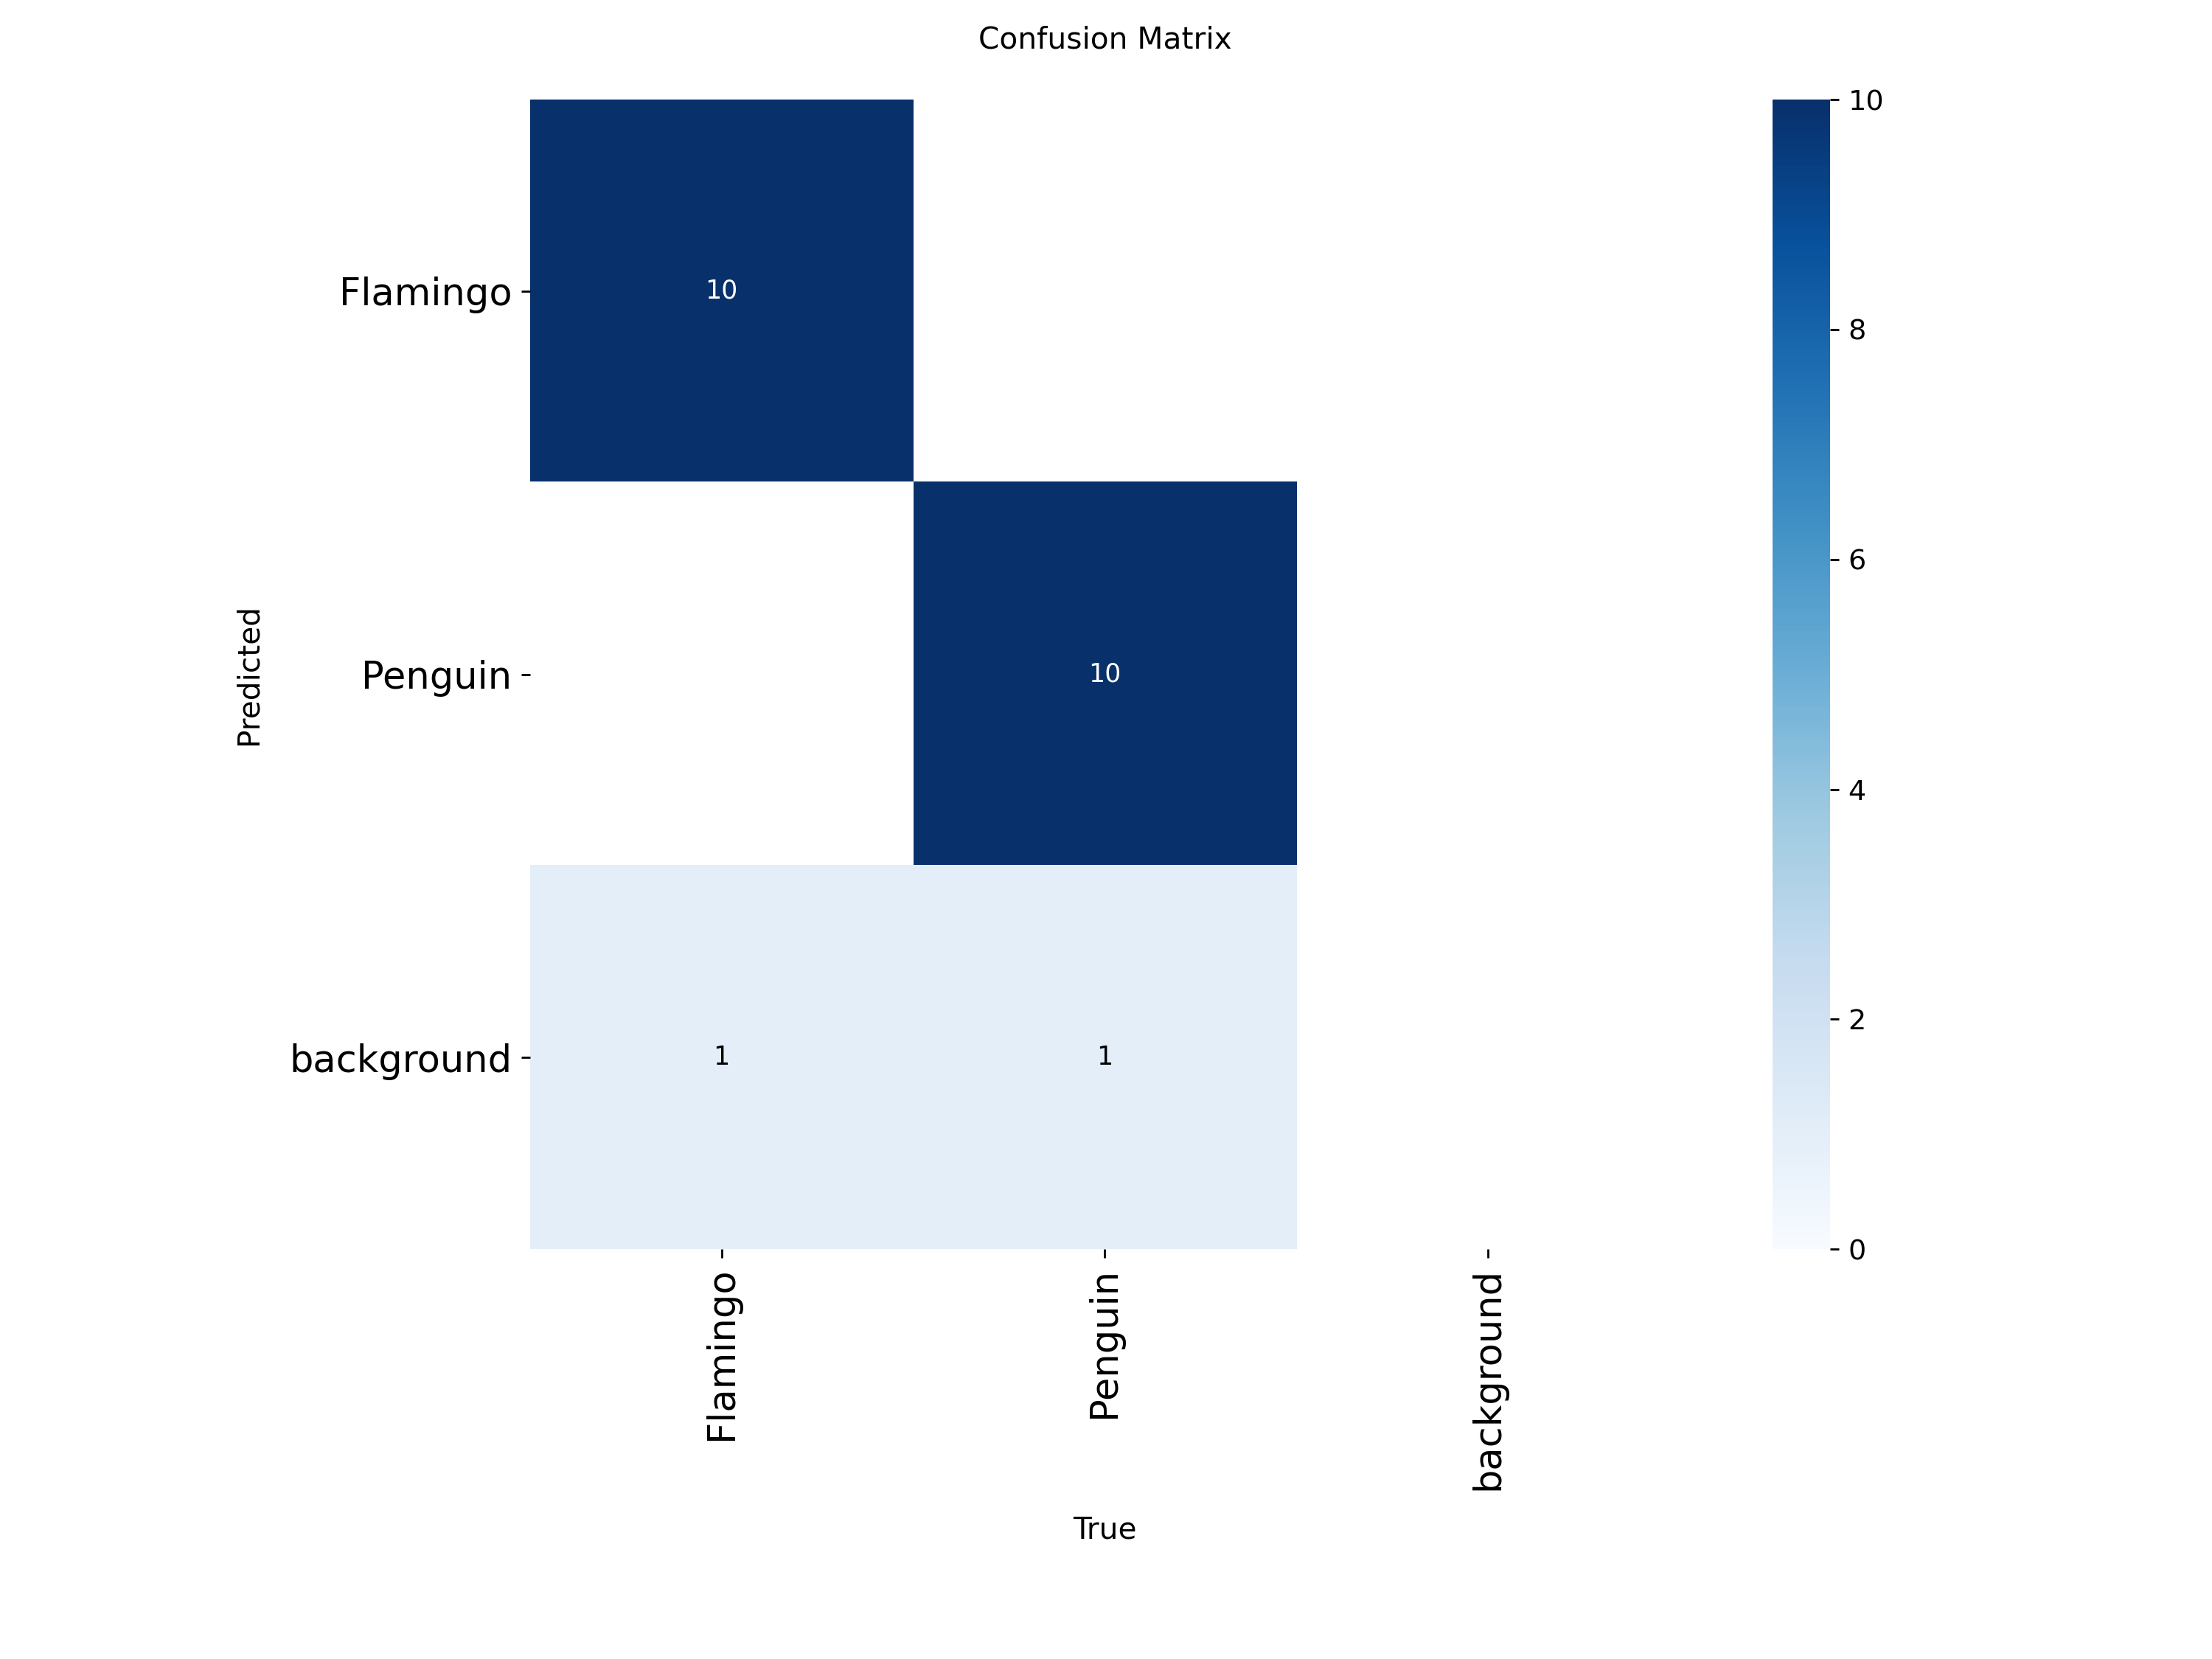

In [12]:
IPyImage(filename='./runs/detect/baseline_n/confusion_matrix.png', width=600)

In [45]:
#model = YOLO('./runs/detect/baseline_n/weights/best.pt')
model = YOLO('./runs/detect/finetuning_l/weights/best.pt')
preds = model('./datasets/birds-penguins-and-flamingo/test/images')


image 1/10 /content/datasets/birds-penguins-and-flamingo/test/images/006_jpg.rf.b8ac5e1d3b6f751e043614f654681a18.jpg: 640x640 1 Flamingo, 47.4ms
image 2/10 /content/datasets/birds-penguins-and-flamingo/test/images/006_jpg.rf.da48b216a17c5299ddd5487e1a125fd8.jpg: 640x640 1 Penguin, 37.9ms
image 3/10 /content/datasets/birds-penguins-and-flamingo/test/images/014_jpg.rf.0a8bedf76aa9d3bdce579f868ac931b5.jpg: 640x640 1 Penguin, 37.9ms
image 4/10 /content/datasets/birds-penguins-and-flamingo/test/images/018_jpg.rf.35c95436f7a2c836aefd24f1157a7d7f.jpg: 640x640 1 Penguin, 37.8ms
image 5/10 /content/datasets/birds-penguins-and-flamingo/test/images/027_jpg.rf.abe289b6d8313ee28ba880f301019444.jpg: 640x640 1 Flamingo, 37.1ms
image 6/10 /content/datasets/birds-penguins-and-flamingo/test/images/029_jpg.rf.d0198ddff4f9b217429c52409d407f04.jpg: 640x640 1 Flamingo, 27.6ms
image 7/10 /content/datasets/birds-penguins-and-flamingo/test/images/034_jpg.rf.ce0579db7257276f6e23e6fcbea9a48f.jpg: 640x640 1 Flam

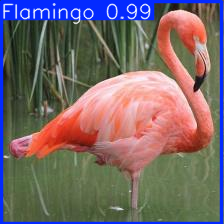

In [46]:
import numpy as np
idx = np.random.randint(len(preds))
preds[idx].show()

In [47]:
print(preds[2].boxes[0])

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.], device='cuda:0')
conf: tensor([0.9836], device='cuda:0')
data: tensor([[ 33.3684,   0.9935, 222.5238, 222.7332,   0.9836,   1.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (224, 224)
shape: torch.Size([1, 6])
xywh: tensor([[127.9461, 111.8634, 189.1554, 221.7397]], device='cuda:0')
xywhn: tensor([[0.5712, 0.4994, 0.8444, 0.9899]], device='cuda:0')
xyxy: tensor([[ 33.3684,   0.9935, 222.5238, 222.7332]], device='cuda:0')
xyxyn: tensor([[0.1490, 0.0044, 0.9934, 0.9943]], device='cuda:0')


In [48]:
UMBRAL_CONF = 0.7
boxes = [box for box in preds[0].boxes if box.conf > UMBRAL_CONF]
print(len(boxes))

1


In [49]:
conteos = Counter([int(box.cls) for box in boxes])
conteos

Counter({0: 1})


Conteos:
Flamingo: 1


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

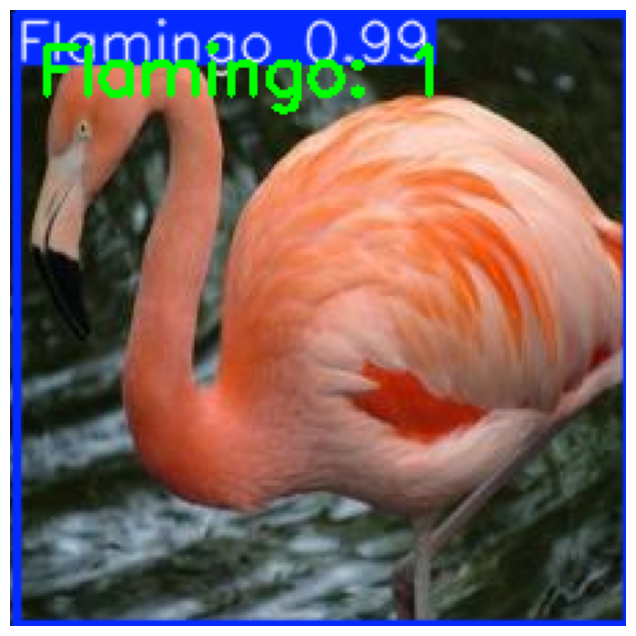

In [50]:
import cv2 # OpenCV
import matplotlib.pyplot as plt

# Mapear categoría de objeto a nombres e imprimir conteos
nombres = model.names
print("\nConteos:")
for cls_id, num in conteos.items():
    print(f"{nombres[cls_id]}: {num}")


# Extraer imagen con los bounding boxes > UMBRAL_CONF
p = preds[6] # Predicción
mascara = p.boxes.conf > UMBRAL_CONF
p.boxes = p.boxes[mascara]
img_bboxes = p.plot() # Imagen con los bounding boxes filtrados

# Añadir anotación mostrando los conteos (esquina superior izquierda)
anotacion = ", ".join([f"{nombres[c]}: {n}" for c, n in conteos.items()])
cv2.putText(img_bboxes, anotacion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
            0.8, (0, 255, 0), 2)

# Convertir imagen de BGR a RGB
img_bboxes_rgb = cv2.cvtColor(img_bboxes, cv2.COLOR_BGR2RGB)

# Y mostrarla
plt.figure(figsize=(12, 8))
plt.imshow(img_bboxes_rgb)
plt.axis("off")

In [51]:
from collections import Counter
import cv2
import matplotlib.pyplot as plt

def mostrar_conteos(modelo, ruta_img, umbral=0.5):
    """
    Función simplificada para contar objetos en una imagen.
    1. Detecta (filtrando por confianza).
    2. Cuenta.
    3. Muestra el resultado.
    """
    # 1. Predicción con filtro automático de confianza (conf=umbral)
    # Esto hace que el modelo ignore las cajas con baja probabilidad
    resultados = modelo(ruta_img, conf=umbral, verbose=False)
    pred = resultados[0]

    # 2. Realizar el conteo
    # pred.boxes.cls es una lista con los IDs de los objetos encontrados (ej: [0, 0, 0])
    clases_encontradas = [int(c) for c in pred.boxes.cls]
    conteos = Counter(clases_encontradas)

    # 3. Imprimir resultados (Texto)
    print(f"\n--- Conteo de objetos (Confianza > {umbral}) ---")
    if not conteos:
        print("No se detectaron objetos con suficiente confianza.")

    for id_clase, cantidad in conteos.items():
        nombre_objeto = modelo.names[id_clase]
        print(f" -> {nombre_objeto}: {cantidad}")

    # 4. Mostrar imagen (Gráfico)
    # plot() dibuja las cajas que pasaron el filtro
    img_con_cajas = pred.plot()

    # Convertir de BGR (OpenCV) a RGB (Matplotlib) para que los colores se vean bien
    img_rgb = cv2.cvtColor(img_con_cajas, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    return conteos

In [52]:
import os

RUTA_TST = './datasets/birds-penguins-and-flamingo/test/images/'
rutas_imgs = [f for f in os.listdir(RUTA_TST) if f.endswith('.jpg')]
rutas_imgs

['006_jpg.rf.da48b216a17c5299ddd5487e1a125fd8.jpg',
 '018_jpg.rf.35c95436f7a2c836aefd24f1157a7d7f.jpg',
 '034_jpg.rf.ce0579db7257276f6e23e6fcbea9a48f.jpg',
 '029_jpg.rf.d0198ddff4f9b217429c52409d407f04.jpg',
 '006_jpg.rf.b8ac5e1d3b6f751e043614f654681a18.jpg',
 '014_jpg.rf.0a8bedf76aa9d3bdce579f868ac931b5.jpg',
 '049_jpg.rf.d4697efb88c0755b230056285548aefa.jpg',
 '050_jpg.rf.699e5da78e15d5778695e2d64053e0d7.jpg',
 '044_jpg.rf.db2dd323441e654dce5019624fb5b75c.jpg',
 '027_jpg.rf.abe289b6d8313ee28ba880f301019444.jpg']


--- Conteo de objetos (Confianza > 0.5) ---
 -> Penguin: 1


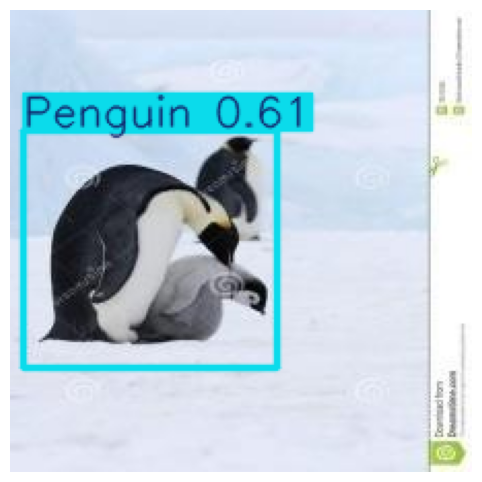

In [53]:
conteo = mostrar_conteos(model, RUTA_TST + rutas_imgs[6])

In [54]:
import pandas as pd
def cear_metricas(modelo:str):
  metrics_path = "./runs/detect/{modelo}/results.csv"
  df = pd.read_csv(df = pd.read_csv(metrics_path, sep=',', skipinitialspace=True))
  time = df["time"].sum()
  box_loss = df["test/box_loss"].mean()
  cls_loss = df["metrics/recall(B)"]

In [23]:


# 1. Cargar el modelo (nano, el más pequeño)
model = YOLO("yolo11s.pt")
inicio = time.time()
# Afinar el modelo
baseline_s = model.train(data=yaml_path,
                      epochs=40 , # Número de iteraciones
                      imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                      #batch = 32,
                      #patience = 10, Si en 5 épocas seguidas no mejora el mAP, para el entrenamiento
                      plots=True, # Guardar gráficos de entrenamiento
                      name = "baseline_s"
                      )
fin = time.time()
time_baseline_s = fin - inicio

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

In [24]:


# 1. Cargar el modelo (nano, el más pequeño)
inicio = time.time()
model = YOLO("yolo11l.pt")

# Afinar el modelo
baseline_l = model.train(data=yaml_path,
                      epochs=10, # Número de iteraciones
                      imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                      #batch = 32,
                     # patience = 5, Si en 5 épocas seguidas no mejora el mAP, para el entrenamiento
                      plots=True, # Guardar gráficos de entrenamiento
                      name = "baseline_l"
                      )
final = time.time()
beaseline_l_time = final - inicio

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_l, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

In [25]:
model_s = YOLO("yolo11s.pt")

In [26]:
# Ver la estructura del modelo
print("Estructura del modelo YOLO11:")
print(model_s.model)

# Contar parámetros totales
total_params = sum(p.numel() for p in model_s.model.parameters())
print(f"\nTotal de parámetros: {total_params:,}")

Estructura del modelo YOLO11:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act)

In [27]:
# Contar el número de capas/módulos
num_layers = len(list(model_s.model.modules()))
print(f" Total de módulos en el modelo: {num_layers}")

 Total de módulos en el modelo: 319


In [28]:
for param in model_s.parameters():
    param.requires_grad = True

In [29]:
# Método 1: Usar el parámetro 'freeze' durante el entrenamiento
# Congela las primeras N capas (por ejemplo, las primeras 10)

finetuning_s = model_s.train(
    data= yaml_path,
    epochs=50,    # Aumentamos un poco las épocas para afinar
    imgsz=640,
    freeze=10,         #  CLAVE: le estamos diciendo a Ultralytics que congele los primeros 10 bloques principales del modelo, que corresponden al backbone.
    lr0=0.005,           #  Learning rate reducido (mitad del estándar) para ser delicados
    plots=True,
    name='finetuning_s'
)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=finetuning_s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

<H1> FINE TUNNING </H1>

In [30]:
model = YOLO("yolo11l.pt")

In [31]:
# Ver la estructura del modelo
print("Estructura del modelo YOLO11:")
print(model.model)

# Contar parámetros totales
total_params = sum(p.numel() for p in model.model.parameters())
print(f"\nTotal de parámetros: {total_params:,}")

Estructura del modelo YOLO11:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       

In [32]:
# Contar el número de capas/módulos
num_layers = len(list(model.model.modules()))
print(f" Total de módulos en el modelo: {num_layers}")

 Total de módulos en el modelo: 631


In [33]:
 #Ver los primeros módulos (backbone)
print("\n Primeros 15 módulos (BACKBONE):")
for i, (name, module) in enumerate(list(model.model.named_modules())[:238]):
    print(f"  Capa {i}: {name} -> {type(module).__name__}")



 Primeros 15 módulos (BACKBONE):
  Capa 0:  -> DetectionModel
  Capa 1: model -> Sequential
  Capa 2: model.0 -> Conv
  Capa 3: model.0.conv -> Conv2d
  Capa 4: model.0.bn -> BatchNorm2d
  Capa 5: model.0.act -> SiLU
  Capa 6: model.1 -> Conv
  Capa 7: model.1.conv -> Conv2d
  Capa 8: model.1.bn -> BatchNorm2d
  Capa 9: model.2 -> C3k2
  Capa 10: model.2.cv1 -> Conv
  Capa 11: model.2.cv1.conv -> Conv2d
  Capa 12: model.2.cv1.bn -> BatchNorm2d
  Capa 13: model.2.cv2 -> Conv
  Capa 14: model.2.cv2.conv -> Conv2d
  Capa 15: model.2.cv2.bn -> BatchNorm2d
  Capa 16: model.2.m -> ModuleList
  Capa 17: model.2.m.0 -> C3k
  Capa 18: model.2.m.0.cv1 -> Conv
  Capa 19: model.2.m.0.cv1.conv -> Conv2d
  Capa 20: model.2.m.0.cv1.bn -> BatchNorm2d
  Capa 21: model.2.m.0.cv2 -> Conv
  Capa 22: model.2.m.0.cv2.conv -> Conv2d
  Capa 23: model.2.m.0.cv2.bn -> BatchNorm2d
  Capa 24: model.2.m.0.cv3 -> Conv
  Capa 25: model.2.m.0.cv3.conv -> Conv2d
  Capa 26: model.2.m.0.cv3.bn -> BatchNorm2d
  Capa 27:

In [34]:
for param in model.parameters():
    param.requires_grad = True

In [35]:
# Método 1: Usar el parámetro 'freeze' durante el entrenamiento
# Congela las primeras N capas (por ejemplo, las primeras 10)

finetunning_l = model.train(
    data= yaml_path,
    epochs=40,    # Aumentamos un poco las épocas para afinar
    imgsz=640,
    freeze=10,         #  CLAVE: le estamos diciendo a Ultralytics que congele los primeros 10 bloques principales del modelo, que corresponden al backbone.
    lr0=0.005,           #  Learning rate reducido (mitad del estándar) para ser delicados
    plots=True,
    name='finetuning_l'
)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=finetuning_l, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

In [ ]:
import os

RUTA_TST = './datasets/birds-penguins-and-flamingo/test/images/'
rutas_imgs = [f for f in os.listdir(RUTA_TST) if f.endswith('.jpg')]
rutas_imgs